# Self-Driving Cab

[Taxi](https://gym.openai.com/envs/Taxi-v2/) is one of the environments in the gym toolkit. It is a simulation of a self-driving taxicab in a simplified environment (a 5x5 grid).

There are 4 locations (labeled by different letters) and the Taxi's job is to pick up the passenger at one location and drop her off in another.

We also want the taxi to:
* Drop off passengers at the right location
* Deliver the passenger as fast as possible
* Take care of the passenger and follow traffic rules

To model this as a reinforcement learning solution we'll need to consider: **rewards**, **states**, and **actions**.

Recall the learning process for reinforcement learning:
1. Observation of the environment
2. Deciding how to act
3. Acting accordingly
4. Receiving a reward or penalty
5. Learning from experiences and refining strategy
6. Iterate until optimal strategy is found

## 1. Rewards

Since the **agent** (the Taxi) learning from rewards, we need to understand how the environment rewards and/or penalizes the agent.
* The agent receives a high positive reward for a successful dropoff: +20 points
* The agent gets a slight negative reward for not making it to the destination every time-step: -1 point
* The agent is penalized if it tries to drop-off a passenger in the wrong location: -10 points

Luckily, the gym environment takes care of when the agent receives rewards/penalties and how much.

## 2. State Space

The **State Space**  is is the set of all possible situations the taxi could be in. The state contains useful information the agent needs to make the right action.

In this environment we have a 5x5 grid, giving us 25 locations the taxi can inhabit. These 25 locations are part of the **State Space**.

Let's take a look at an example of the environment.

In [8]:
import gym
env = gym.make("Taxi-v2").env
env.s = 240
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



This is just one state of the State Space.

We also have four different locations (R, G, Y, B), these are the drop-off locations. 

In this example state, the Passenger is a drop-off Y (the Passenger location turns purple). The Passenger can be at any of the four drop-off locations or in the taxi, giving her five possible locations.

These four drop-off locations and five Passenger locations are part of the State Space as well. In total the taxi environment has, **5 x 5 x 5 x 4 = 500** total possible states.

## 3. Action Space

The agent encounters one of the 500 states and it takes an action. The action in our case can be to move in a direction or decide to pickup/dropoff a passenger.

In other words, we have **six possible actions**:
0. south
1. north
2. east
3. west
4. pickup
5. dropoff

This is the **Action Space**: the set of all the actions that our agent can take in a given state.

Note that the environment also contains walls (represented by the **pipe**, "|"). In the environment's code, it will simply provide a -1 penalty for every wall hit and the taxi won't move anywhere. This will rack up penalties causing the taxi to consider going around the wall.

## Overview of Gym's Interface

The core gym interface is env, which is the unified environment interface. The following are the env methods that will be helpful:

* **env.reset:** Resets the environment and returns a random initial state.
* **env.step(action):** Step the environment by one timestep. Returns:
  * **observation:** Observations of the environment
  * **reward:** If your action was beneficial or not
  * **done:** Indicates if we have successfully picked up and dropped off a passenger, also called one episode
  * **info:** Additional info such as performance and latency for debugging purposes
* **env.render:** Renders one frame of the environment (helpful in visualizing the environment)

Note: We are using the .env on the end of make to avoid training stopping at 200 iterations, 

In [11]:
import gym

env = gym.make("Taxi-v2").env

env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Let's verify the Action Space and State Space are what we expect.

In [13]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


Our RL algorithm won't need any more information than these two things. All we need is a way to identify a state uniquely by assigning a unique number to every possible state, and RL learns to choose an action number from 0-5 where:

* 0 = south
* 1 = north
* 2 = east
* 3 = west
* 4 = pickup
* 5 = dropoff

Recall that the 500 states correspond to a encoding of the Taxi's location, the Passenger's location, and the drop-off location.

Reinforcement Learning will learn a mapping of states to the optimal action to perform in that state by exploration, i.e. the agent explores the environment and takes actions based off rewards defined in the environment.

The optimal action for each state is the action that has the highest cumulative long-term reward.

## The Reward Table

When the Taxi environment is created, there is an initial Reward table that's also created, called `P`. We can think of it like a matrix that has the number of states as rows and number of actions as columns, i.e. a states × actions matrix.

Since every state is in this matrix, we can see the default reward values assigned to our illustration's state:

In [33]:
env.P[240]

AttributeError: 'TimeLimit' object has no attribute 'P'

This dictionary has the structure:

```
{action: [(probability, nextstate, reward, done)]}
```

A few things to note:
* The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff) the taxi can perform at our current state.
* In this env, probability is always 1.0.
* The nextstate is the state we would be in if we take the action at this index of the dict
* All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5)
* done is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode

## Solving Without Reinforment Learning: Random Search

We can try to brute-force our way to solve the problem without RL. Starting with a random search is a good way to benchmark your solutions.

We'll create a loop that runs until one passenger reaches their destination (one episode).

Recall from the previous lab that env.action_space.sample() method selects one random action from set of all possible actions. We'll have the agent use this to choose actions.

**Note:** Sine we create the environment with "make("Taxi-v2")" rather than just "make("Taxi-v2").env", it will stop running after 200 timesteps.

In [50]:
import gym

env = gym.make("Taxi-v2")

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation
done = False

env.reset()

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 200
Penalties incurred: 63


Since it would be nice to see what the agent is doing, we've stored each frame in the 'frame' list. Let's write a function that can replay these frames for us.

In [52]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'].getvalue())
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)

Now we can pass a list of frames to the print_frames() function to replay an episode.

**Note: It may take a while to replay all the frames if the episode took many timesteps. You can stop the cell from running by interrupting the kernel. To do so: Click the stop button; or go to Kernel-> Interrupt **

In [53]:
print_frames(frames)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Timestep: 200
State: 96
Action: 2
Reward: -1


Let's make a function that can run one episode for us.

In [39]:
'''
Returns:
frames - A list of frames from every timestep
epochs - The number of timesteps taken
penalties - The total number of penalties received
'''
def run_episode(env):  
    epochs = 0
    penalties, reward = 0, 0

    frames = [] # for animation
    done = False

    env.reset()

    while not done:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )

        epochs += 1

    return frames, epochs, penalties

In [57]:
env = gym.make("Taxi-v2").env # create environment without 200 timestep cut-off
_, timesteps, penalties = run_episode(env)

print("Timesteps taken: {}".format(timesteps))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 4327
Penalties incurred: 1433


Now we can write a random research function so we can more easily evaluate its performance.

In [63]:
'''
Returns:
timesteps - The number of timesteps taken
penalties - The total number of penalties received
'''
def random_search(num_episodes):
    num_episodes = num_episodes
    time_list = []
    penalty_list = []
    
    for episodes in range(1, num_episodes+1):
        _, timesteps, penalties = run_episode(env)
        time_list.append(timesteps)
        penalty_list.append(penalties)
        
    return time_list, penalty_list

## Evaluate Random Search

Let's start by running random search 100 times. We'll need matplot and numpy for processing and viewing the results.

In [81]:
import matplotlib.pyplot as plt
import numpy as np

In [78]:
%%time
## %% time is a system call ##
## It will display how much time it took to run this code block ##


times, penalties = random_search(100)  # Run random_search() 100 times

Wall time: 7.12 s


Now we can plot histograms for timesteps and penalties.

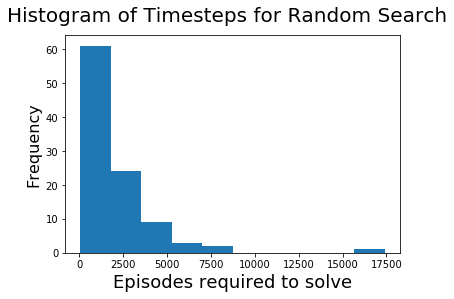

In [79]:
fig = plt.figure()
plt.hist(times)
fig.suptitle('Histogram of Timesteps for Random Search', fontsize=20)
plt.xlabel('Episodes required to solve', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.show()

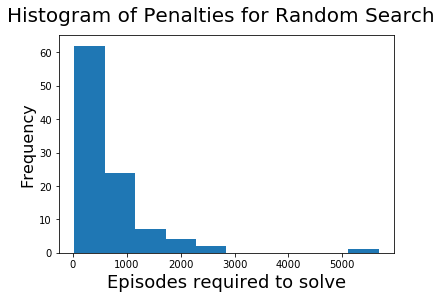

In [80]:
fig = plt.figure()
plt.hist(penalties)
fig.suptitle('Histogram of Penalties for Random Search', fontsize=20)
plt.xlabel('Episodes required to solve', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.show()

And let's also calculate the mean values:

In [82]:
mean_time = np.array(times).mean()
mean_penalty = np.array(penalties).mean()

print("Mean timesteps taken: {}".format(mean_time))
print("Mean penalties incurred: {}".format(mean_penalty))

Mean timesteps taken: 2062.35
Mean penalties incurred: 665.97


## Solving with RL: Q-Learning

Essentially, Q-learning lets the agent use the environment's rewards to learn, over time, the best action to take in a given state.

In our Taxi environment, we have the reward table, P, that the agent will learn from. It does thing by looking receiving a reward for taking an action in the current state, then updating a Q-value to remember if that action was beneficial.

The values store in the Q-table are called a Q-values, and they map to a (state, action) combination.

A Q-value for a particular state-action combination is representative of the "quality" of an action taken from that state. Better Q-values imply better chances of getting greater rewards.

For example, if the taxi is faced with a state that includes a passenger at its current location, it is highly likely that the Q-value for pickup is higher when compared to other actions, like dropoff or north.

Q(state,action)←(1−α)Q(state,action)+α(reward+γmaxaQ(next state,all actions))

In [83]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [84]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

Wall time: 26.6 s


In [85]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 12.53
Average penalties per episode: 0.0


## Write your own program

Next, I want you to use this code as a reference to write your own program that can solve a different environment: Acrobot-v1

In [88]:
env = gym.make("Acrobot-v1")

observation = env.reset()

# Observation: 6 continuous values
print(observation)
print(env.observation_space)

# Actions: 3 discrete values
print(env.action_space)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[ 0.99839889  0.05656546  0.99998782  0.00493458  0.08323316  0.03488322]
Box(6,)
Discrete(3)
